In [1]:
import pandas as pd

In [2]:
file_path = 'merged_data/final_data.csv'


In [5]:
merged_data = pd.read_csv(file_path)

In [6]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0.1           9994 non-null   int64  
 1   Country_Code           9994 non-null   object 
 2   total_votes            9994 non-null   int64  
 3   average_quality_score  9994 non-null   float64
 4   Unnamed: 0             9994 non-null   int64  
 5   Year                   9994 non-null   int64  
 6   GDP                    9994 non-null   int64  
 7   Population             9994 non-null   float64
 8   Country_Name           9994 non-null   object 
 9   GDP_per_Capital        9994 non-null   float64
 10  population_rank        9994 non-null   float64
 11  gdp_rank               9994 non-null   float64
 12  gdp_per_capita_rank    9994 non-null   float64
 13  total_votes_rank       9994 non-null   float64
 14  average_quality_rank   9994 non-null   float64
 15  stro

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Filter top 5 countries with most hegemony
top_10_strong_hegemony_country = []


for year in merged_data['Year'].unique():
    # Compute hegemony
    merged_data['strong_hegemony'] = merged_data['gdp_rank'] - merged_data['average_quality_rank']
    merged_data['weak_hegemony'] = merged_data['gdp_rank'] - merged_data['total_votes_rank']
    top_10_hegemony_countries_year = merged_data[merged_data['Year'] == year].nlargest(5, 'strong_hegemony')
    top_10_strong_hegemony_country.append(top_10_hegemony_countries_year)

top_10_hegemony_countries = pd.concat(top_10_strong_hegemony_country)

# Calculate the correlation coefficient
correlation = top_10_hegemony_countries[['weak_hegemony', 'strong_hegemony']].corr().iloc[0, 1]

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.scatter(df['new_cases'], df['new_deaths'], alpha=0.3, color='blue')
plt.title('Correlation between the number of new COVID-19 cases and new deaths in Portugal', fontsize=15, fontweight='bold')

sns.regplot(x='new_cases', y='new_deaths', data=df, scatter=False, color='red')

plt.ylabel('New Deaths')
plt.xlabel('New Cases')
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000], ['0', '50k', '100k', '150k', '200k', '250k', '300k', '350k', '400k', '450k'])

plt.grid(True, linestyle='--', color='grey', linewidth=0.5)

plt.tight_layout()

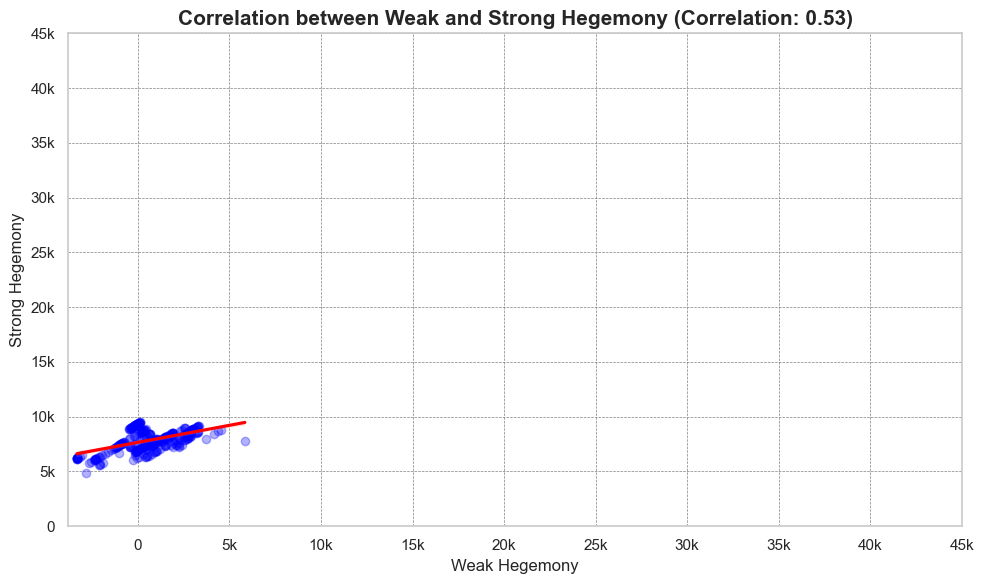

In [20]:
sns.set(style="whitegrid")
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
plt.scatter(top_10_hegemony_countries['weak_hegemony'], 
            top_10_hegemony_countries['strong_hegemony'],
            alpha=0.3, color='blue')
plt.title(f'Correlation between Weak and Strong Hegemony (Correlation: {correlation:.2f})', fontsize=15, fontweight='bold')

sns.regplot(x='weak_hegemony', y='strong_hegemony', data=top_10_hegemony_countries, scatter=False, color='red')

# Add labels
plt.xlabel('Weak Hegemony')
plt.ylabel('Strong Hegemony')

plt.xticks([0,  1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500], 
           ['0', '1k', '1.5k', '2k', '2.5k', '3k', '3.5k', '4k', '4.5k'])

plt.yticks([0,  1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500], 
           ['0', '1k', '1.5k', '2k', '2.5k', '3k', '3.5k', '4k', '4.5k'])

plt.grid(True, linestyle='--', color='grey', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()